## Complexity-based Strategy Selection

By determining query complexity, **Adaptive-RAG** applies an efficient retrieval strategy, choosing between:

- **Non-retrieval:** Simple queries are handled directly by the LLM without retrieval.  
- **Single-step retrieval:** Queries that need extra information from one document are processed in a single retrieval step.  
- **Multi-step retrieval:** Complex, multi-hop queries involve iterative retrieval, integrating multiple documents and employing reasoning chains.

---

## Query Complexity Classifier

**Adaptive-RAG** introduces a classifier to assess query complexity levels:

- **A:** Simple — handled directly by the LLM.  
- **B:** Moderately complex — requires single-step retrieval.  
- **C:** Complex — requires multi-step retrieval.  

The classifier is trained using data derived from analyzing the success rates of each retrieval method and leveraging inductive biases from existing datasets.

---

## Efficiency and Accuracy Balance

The framework is structured to optimize for both **computational efficiency** and **answer accuracy**, selecting simpler approaches for straightforward questions to conserve computational resources.  
This balance is crucial in real-world applications, as not all queries necessitate extensive retrieval and reasoning.


----------------------------------------

----------------------------------

### Implementation in LangGraph
Implementing **Adaptive-RAG** in LangGraph involves setting up a query complexity classifier, then designing a state graph that branches into different paths based on the classifier's output. The process aligns with the paper’s methodology.

#### 1. Define the Query Complexity Classifier
- Train a classifier using a smaller language model (e.g., **T5-Large**) that categorizes queries into three complexity levels (**A**, **B**, **C**).  
- Integrate the classifier as a separate **LangGraph node** to evaluate each query before selecting a retrieval strategy.

#### 2. Construct Retrieval Nodes and Paths
- Define three distinct retrieval nodes for **non-retrieval**, **single-step retrieval**, and **multi-step retrieval**.  
- Implement a `retrieve()` function that conditionally selects the retrieval strategy based on the classifier’s output.

#### 3. Multi-step Retrieval for Complex Queries
- For queries classified as **C (complex)**, enable an iterative retrieval process where documents are fetched and assessed in multiple rounds until a satisfactory response is produced.  
- Incorporate reasoning chains and intermediate answers as part of this iterative process.

#### 4. Decision-Making Logic in LangGraph
- Add **decision nodes** that use the classifier’s output to route queries through the appropriate retrieval path.  
- Implement **conditional edges** from the classifier to each retrieval node (non-retrieval, single-step, multi-step).


In [20]:
import getpass, os
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [60]:
from typing import Literal, List, TypedDict
from pprint import pprint
from pydantic import BaseModel, Field
from IPython.display import display, HTML, Image

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langgraph.graph import StateGraph, START, END

web_search_tool = TavilySearchResults(k=3)

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

docs = [WebBaseLoader(url).load() for url in urls]
print(f"Loaded {len(docs)} documents from URLs.")

docs_list = [item for sublist in docs for item in sublist]
print(f"Flattened to {len(docs_list)} document items.")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500)
doc_splits = text_splitter.split_documents(docs_list)
print(f"Split into {len(doc_splits)} documents chunks")

Loaded 3 documents from URLs.
Flattened to 3 document items.
Split into 404 documents chunks


In [34]:
persist_dir = "./chroma_db"
vectorstore = Chroma.from_documents(
    doc_splits, 
    collection_name="adaptive_rag", 
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    persist_directory=persist_dir,
)
print("Vectorstore created")


retriever = vectorstore.as_retriever()
print("Retreiver created.")

Vectorstore created
Retreiver created.


In [ ]:
# Define the structured output model
class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "web_search"]

route_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert at routing user questions to a vectorstore or web search.
    
    The vectorstore contains documents about:
    - LLM-powered autonomous agents (reasoning, planning, tool use, memory)
    - Prompt engineering techniques (zero-shot, few-shot, chain-of-thought)
    - Adversarial attacks on LLMs (jailbreaking, prompt injection)
    
    Use the vectorstore for questions about these topics.
    Use web_search for questions about current events, specific products, or topics outside the vectorstore domain.
    """),
    ("human", "{question}")
])

question_router = route_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(RouteQuery)

In [62]:
class QueryComplexity(BaseModel):
    """Classify query complexity for adaptive retreival strategy."""
    complexity: Literal["simple", "moderate", "complex"] = Field(description="simple: direct LLM answer | moderate: single-step retreival | complex: multi-step retreival")
    reasoning: str = Field(description="Brief explanation of complexity classification")

complexity_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert at assessing query complexity for retrieval systems.
    
    Classify queries as:
    - **simple**: Factual questions the LLM can answer directly (e.g., "What is Python?")
    - **moderate**: Requires retrieving information from 1-2 documents (e.g., "What are types of agent memory?")
    - **complex**: Multi-hop reasoning across multiple documents (e.g., "Compare agent memory with prompt engineering in adversarial scenarios")
    
    Consider: specificity, reasoning depth, number of concepts involved.
    """),
    ("human", "{question}")
])

complexity_classifier = complexity_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0.1).with_structured_output(QueryComplexity)

In [63]:
def generate_direct(state):
    """Generate answer without retreival for simple queries"""
    print("[Node] Generating direct answer (no retreival)...")

    prompt = ChatPromptTemplate.from_template("Answer thi question concisely based on your knowledge: {question}")
    chain = prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0.7) | StrOutputParser()
    generation = chain.invoke({"question": state["question"]})
    return {"generation": generation, "documents": []}

In [36]:
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", "Evaluate if the document is relevant to the question. Answer 'yes' or 'no'."),
    ("human", "Document: {document}\nQuestion: {question}")
])

retrieval_grader = grade_prompt | ChatOpenAI(model="gpt-4o-mini",temperature=0).with_structured_output(GradeDocuments)

In [ ]:
def web_search(state):
    search_results = web_search_tool.invoke({"query": state["question"]})
    
    web_documents = [
        Document(page_content=result["content"]) for result in search_results if "content" in result
    ]

    return {"documents": web_documents, "question":state["question"]}

In [48]:
def retrieve(state):
    print("[Node] Starting retrieve...")
    question = state["question"]
    print(f"Retrieving documents for question: {question}")
    documents = retriever.invoke(question)
    print(f"Retrieved {len(documents)} documents.")
    return {"documents": documents, "question": question}

def grade_documents(state):
    print("[Node] Starting grade_documents...")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search_needed = "No"
    print(f"Grading {len(documents)} documents for relevance...")

    for i, doc in enumerate(documents):
        print(f"Grading document {i+1}/{len(documents)}...")
        grade = retrieval_grader.invoke({"question": question, "document": doc.page_content}).binary_score
        print(f"Grade result: {grade}")
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT--")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search_needed = "Yes"
            print(f"Web search needed: {web_search_needed}")
            return {"documents": filtered_docs, "question":question, "web_search": web_search_needed}
    
    print(f"Filtered to {len(filtered_docs)} relevant documents.")
    return {"documents": filtered_docs, "question": question, "web_search": web_search_needed}

In [49]:
def generate(state):
    prompt_template = """
    Use the following context to answer the question concisely and accurately:
    Question: {question}
    Context: {context}
    Answer:
    """

    rag_prompt = ChatPromptTemplate.from_template(prompt_template)
    rag_chain = (rag_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser())
    generation = rag_chain.invoke({"context": state["documents"], "question": state["question"]})
    return {"generation": generation}

In [ ]:
# route questions based on source
def route_question(state):
    question = state["question"]
    route_result = question_router.invoke({"question": question})
    source = route_result.datasource
    print(f"[Router] Question: '{question}' -> Routing to: {source}")
    return "web_search" if source == "web_search" else "retrieve"

In [ ]:
def route_by_complexity(state):
    """Router: Choose path based on complexity classification."""
    print("[Node] Classifying complexity...")

    result = complexity_classifier.invoke({"question": state["question"]})
    print(f"Complexity: {result.complexity} - {result.reasoning}")

    complexity = result.complexity
    
    if complexity == "simple":
        print("[Router] Simple query → direct generation")
        return "generate_direct"
    else:
        # For moderate/complex, use existing routing logic
        route_result = question_router.invoke({"question": state["question"]})
        source = route_result.datasource
        print(f"[Router] {complexity.capitalize()} query → {source}")
        return "web_search" if source == "web_search" else "retrieve"

In [58]:
test_questions = [
    "What is agent self reflection?",
    "What are the types of agent memory?",
    "What's the weather in Paris?",
]

for q in test_questions:
    route = question_router.invoke({"question": q})
    print(f"Q: {q}\nRoute: {route.datasource}\n")

Q: What is agent self reflection?
Route: vectorstore

Q: What are the types of agent memory?
Route: vectorstore

Q: What's the weather in Paris?
Route: web_search



In [ ]:
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]
    complexity: str

In [65]:

workflow = StateGraph(GraphState)

workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("generate_direct", generate_direct)

workflow.add_conditional_edges(
    START, 
    route_by_complexity,
    {
        "generate_direct": "generate_direct",
        "web_search": "web_search",
        "retrieve": "retrieve"
    }
)

workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate_direct", END)
workflow.add_edge("generate", END)
app = workflow.compile()

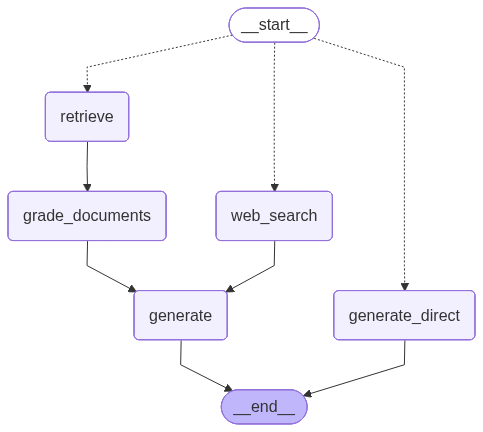

In [66]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

In [67]:
test_scenarios = [
    {"question": "What is machine learning?", "expected_complexity": "simple"},
    {"question": "What are the types of agent memory?", "expected_complexity": "moderate"},
    {"question": "How do agent memory techniques compare with prompt engineering for adversarial robustness?", "expected_complexity": "complex"},
    {"question": "What's the latest iPhone release?", "expected_complexity": "moderate"},
]

for scenario in test_scenarios:
    print(f"\n{'='*80}")
    print(f"Testing: {scenario['question']}")
    print(f"Expected complexity: {scenario['expected_complexity']}")
    print(f"{'='*80}\n")
    
    for output in app.stream({"question": scenario["question"]}):
        for key, value in output.items():
            print(f"Node '{key}':")
            if key == "generate" or key == "generate_direct":
                print(f"Answer: {value.get('generation', 'N/A')}")
            else:
                pprint(value, indent=2, width=80, depth=1)
            print("\n---\n")


Testing: What is machine learning?
Expected complexity: simple

[Node] Classifying complexity...
Complexity: simple - The query is a straightforward factual question that can be answered directly without the need for additional context or document retrieval.
[Router] Simple query → direct generation
[Node] Generating direct answer (no retreival)...
Node 'generate_direct':
Answer: Machine learning is a subset of artificial intelligence that involves the use of algorithms and statistical models to enable computers to learn from and make predictions or decisions based on data. It involves training models on datasets to identify patterns and improve their performance over time without being explicitly programmed for specific tasks.

---


Testing: What are the types of agent memory?
Expected complexity: moderate

[Node] Classifying complexity...
Complexity: moderate - The query asks for specific types of agent memory, which requires retrieving information from one or two documents that de